In [214]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt

In [25]:
nside=256
freqs=np.arange(544,1088,step=1)
# nfreqs=len(freqs)
nfreqs=181
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [20]:
lmax

767

In [ ]:
smoothed_hi_maps=np.load("smoothed_hi_maps.npy") #first chunk nf=181
smoothed_maps= np.load("smoothed_maps_1_smallbeam.npy") #first chunk
noise_maps= np.load("noise_nf.npy")

In [ ]:
noise_maps_1=noise_maps[:181] # take only first chunk

We observe $$x_\ell = s_\ell + n_\ell + f_\ell$$
The Model Covariance is written as:
$$C_\ell^{\text{model}} = C_{\text{HI}} + C_{\text{noise}} + F P_\ell F^T$$
Where:

- $F \in \mathbb{R}^{N_c \times r}$: foreground mixing matrix (unknown)
- $P_\ell \in \mathbb{R}^{r \times r}$: power spectra of foreground components at multipole ℓ (unknown)
- $r≪N_c$: the rank of the foreground model

$N_c$ is the number of channels (frequency bins), 
and $r$ is the foreground model rank $\approx 3$

In [29]:
def compute_cl(almmaps:np.ndarray, l_max: int, n_freq: int)-> tuple[np.ndarray, np.ndarray]:
    r"""
    Compute the power spectrum C_l from alm_maps.

    The power spectrum is computed as:

    \[ \hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm} \]
    
    Parameters:
    ----------
    almmaps : np.ndarray
        Array of shape (n_freq, num_alm) containing spherical harmonic coefficients.
    
    l_max : int
        Maximum multipole lmax.
    
    n_freq : int
        Number of frequency channels.
    
    Returns:
    -------
    alm_p : np.ndarray
        Truncated spherical harmonic values for m>0.
    
    C_l : np.ndarray
        Power spectrum array of shape (lmax+1, n_freq, n_freq).
    """
    Cl = np.zeros((l_max + 1, n_freq, n_freq), dtype=float)
    
    for l in range(l_max + 1):
        
        index = np.zeros((l + 1), dtype=int)
        
        for m in range(l + 1):
            index[m] = hp.Alm.getidx(l_max, l, m)  # Get Alm index
        
        almp = almmaps[:, index]  # Extract relevant alm values
        print(f"Computing power spectra {l}")
        # Compute C_l
        Cl[l, :, :] = np.real(np.outer(almp[:, 0], almp[:, 0]))
        
        for m in range(1, l + 1):  # Sum over m
            Cl[l, :, :] += 2 * np.real(np.outer(almp[:, m], np.conj(almp[:, m])))
    
    return Cl

In [164]:
def compute_covariance(maps, lmax, almsize, nfreqs):
    alms=np.zeros((nfreqs, almsize), dtype=complex) 
    
    for nf in range(nfreqs):
        print(f"Converting maps {nf}")
        alms[nf,:]= hp.map2alm(maps[nf,:], lmax=lmax) 
        
    cl=compute_cl(alms, lmax, nfreqs)
    
    return cl

In [ ]:
# Getting the model covariance of HI and noise which we assume to be known
# F and P_l are free parameters to be estimated

cl_noise= compute_covariance(noise_maps_1, lmax, almsize, nfreqs)
cl_hi= compute_covariance(smoothed_hi_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

Diagonalize the power spectra, so we have $C^{ij}(l)$ 

In [60]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((lmax+1, nfreqs, nfreqs))
    for l in range (lmax+1):
        print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag

In [61]:
hi= diagonalize_matrices(cl_hi, nfreqs)
noise= diagonalize_matrices(cl_noise, nfreqs)

Diagonalizing matrix 0
Diagonalizing matrix 1
Diagonalizing matrix 2
Diagonalizing matrix 3
Diagonalizing matrix 4
Diagonalizing matrix 5
Diagonalizing matrix 6
Diagonalizing matrix 7
Diagonalizing matrix 8
Diagonalizing matrix 9
Diagonalizing matrix 10
Diagonalizing matrix 11
Diagonalizing matrix 12
Diagonalizing matrix 13
Diagonalizing matrix 14
Diagonalizing matrix 15
Diagonalizing matrix 16
Diagonalizing matrix 17
Diagonalizing matrix 18
Diagonalizing matrix 19
Diagonalizing matrix 20
Diagonalizing matrix 21
Diagonalizing matrix 22
Diagonalizing matrix 23
Diagonalizing matrix 24
Diagonalizing matrix 25
Diagonalizing matrix 26
Diagonalizing matrix 27
Diagonalizing matrix 28
Diagonalizing matrix 29
Diagonalizing matrix 30
Diagonalizing matrix 31
Diagonalizing matrix 32
Diagonalizing matrix 33
Diagonalizing matrix 34
Diagonalizing matrix 35
Diagonalizing matrix 36
Diagonalizing matrix 37
Diagonalizing matrix 38
Diagonalizing matrix 39
Diagonalizing matrix 40
Diagonalizing matrix 41
Di

Now we bin the power spectra, with $\Delta \ell=10$?

In [102]:
delta_ell=10

In [146]:
def bin_spectra(cl,nside, delta):
    b= nmt.NmtBin.from_lmax_linear(3*nside-1, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))
    for nf in range(nfreqs):
        cl_binned [:,nf, nf]= b.bin_cell(cl[:,nf,nf])
    return leff,n_bins,cl_binned

In [147]:
leff,n_bins, noise_binned= bin_spectra(noise, nside, delta_ell)
*_,hi_binned= bin_spectra(hi, nside, delta_ell)

In [152]:
leff

array([  6.5,  16.5,  26.5,  36.5,  46.5,  56.5,  66.5,  76.5,  86.5,
        96.5, 106.5, 116.5, 126.5, 136.5, 146.5, 156.5, 166.5, 176.5,
       186.5, 196.5, 206.5, 216.5, 226.5, 236.5, 246.5, 256.5, 266.5,
       276.5, 286.5, 296.5, 306.5, 316.5, 326.5, 336.5, 346.5, 356.5,
       366.5, 376.5, 386.5, 396.5, 406.5, 416.5, 426.5, 436.5, 446.5,
       456.5, 466.5, 476.5, 486.5, 496.5, 506.5, 516.5, 526.5, 536.5,
       546.5, 556.5, 566.5, 576.5, 586.5, 596.5, 606.5, 616.5, 626.5,
       636.5, 646.5, 656.5, 666.5, 676.5, 686.5, 696.5, 706.5, 716.5,
       726.5, 736.5, 746.5, 756.5])

In [123]:
hi_binned.shape

(76, 181, 181)

Now we can design the free parameteres that we want to find using SMICA. 

In [258]:
r=3 #foreground model rank
def guess_params(nfreqs,n_bins, r):
    
    #Initial guess for F
    F_i= np.random.randn(nfreqs, r) # N_channels x r

    # initial guess for P_l for each bin
    P_l=np.zeros((n_bins, r,r))
    for bin in range(n_bins):
        P_l[bin,:,:]= np.identity(r) #r x r
    return F_i, P_l


In [259]:
F_init,P_b_init = guess_params(nfreqs,n_bins, r)

In [133]:
P_b_init.shape

(76, 3, 3)

In [266]:
F_init.shape

(181, 3)

Define the model covariance $C_b^{\text{model}}$

In [135]:
def model_covariance(C_HI, F, P_b, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b, :,:] + C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b


In [136]:
c_model= model_covariance(hi_binned, F_init, P_b_init,noise_binned, n_bins)

Compute the empirical covariance $\hat{C}_b$ from the combined observed beam smoothed maps.

In [170]:
c_l_hat= compute_covariance(smoothed_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

Now bin the empirical covariance with $\Delta \ell=10$

In [180]:
*_,c_hat= bin_spectra(c_l_hat, nside, delta_ell)

In [181]:
c_hat.shape

(76, 181, 181)

Define the negative log-likelihood/cost-function
$$\mathcal{L} = \sum_b w_b \left[ \log \det C_b^{\text{model}} + \text{Tr} \left( (\hat{C}_b) (C_b^{\text{model}})^{-1} \right) \right]$$
$$\phi(\theta) = \sum_{q=1}^{Q} n_q \left[ \mathrm{tr} \left( \hat{R}_Y(q) R_Y(q; \theta)^{-1} \right) - \log \det \left( \hat{R}_Y(q) R_Y(q; \theta)^{-1} \right) - n \right]$$

Where:

- b: multipole bins
- $w_b$, $n_q$: weight (e.g., number of modes in bin b)
- $\hat{C}_b:$ empirical covariance in bin b
- $n$: number of frequency channels

If F_init and P_b_init are 2D arrays , the params array will be a 1D array of size (nfreqs * r + r * r). Inside the smica function, we need to reshape it back to the 2D structure.

In [ ]:
params_init = np.concatenate([F_init.flatten(), P_b_init.flatten()])

In [277]:
F_init.flatten().shape

(543,)

In [287]:
nfreqs*r

543

In [278]:
P_b_init.flatten().shape

(684,)

In [289]:
n_bins*r*r 

684

In [285]:
684+543

1227

In [292]:
params_init[684:].shape

(543,)

In [293]:
def smica(params,model, empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    P_b_init = params[:n_bins*r * r].reshape((n_bins,r,r))
    F_init = params[n_bins*r * r:].reshape((nfreqs, r))
    
    cost=0
    model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model_inv[b]= np.linalg.inv(model[b])
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv[b]))
        trace=np.trace(np.dot(empirical[b] , model_inv[b]))
        
        term = logdet + trace
        cost += term
        
    return cost

In [294]:
phi=smica(params_init,c_model, c_hat, n_bins,nfreqs, r)

In [295]:
phi

np.float64(424083.4041211164)

In [236]:
np.log(np.linalg.det(c_model[10]))

np.float64(-657.1575435801599)

In [296]:
res = optimize.minimize(
    smica,
    x0=params_init,
    args=(c_model, c_hat, n_bins, nfreqs,r),
    method='L-BFGS-B'
)

KeyboardInterrupt: 

In [ ]:
print("Minimized phi:", res.fun)
print("Success:", res.success)

-------Extra Plots---------

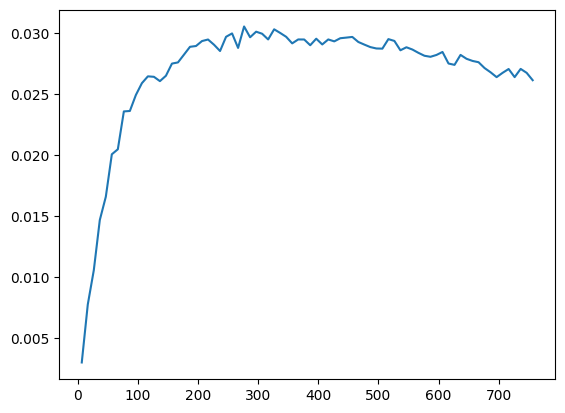

In [185]:

# plt.plot(noise_binned[:,100,100])
plt.plot(leff,hi_binned[:,70,70]+noise_binned[:,70,70])

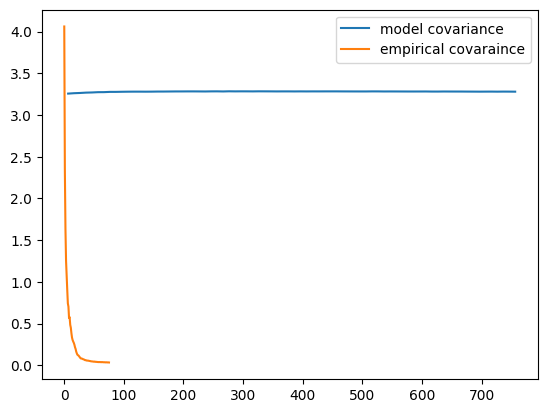

In [188]:
plt.plot(leff,c_model[:,70,70], label="model covariance")
plt.plot(c_hat[:,70,70], label="empirical covaraince")
plt.legend()

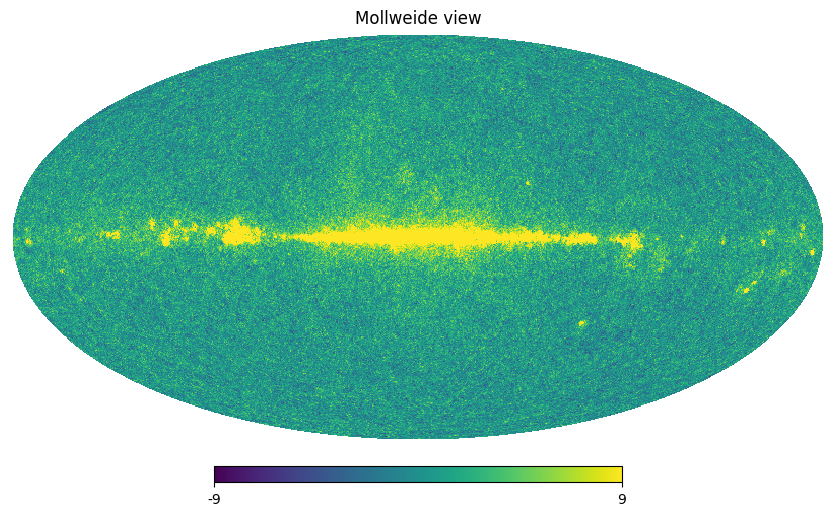

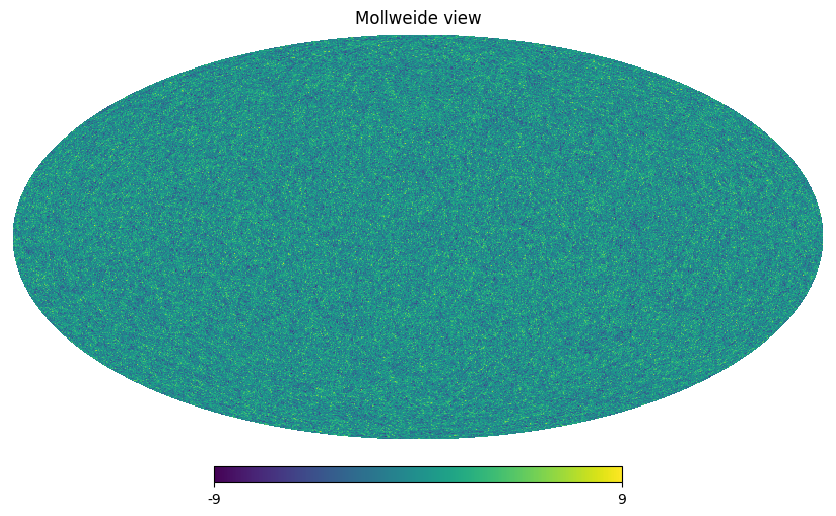

In [162]:
hp.mollview(smoothed_maps[0], min=-9, max=9)
hp.mollview(smoothed_hi_maps[0], min=-9, max=9)